<a href="https://colab.research.google.com/github/AIFahim/Bangla-News-Article-Classification/blob/master/Evaluation_of_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing required Libraries

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.callbacks
import tensorflow_hub as hub

# import tokenization


import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

from keras import backend as K

# import tensorflow.keras.backend as K

In [ ]:
from keras.losses import sparse_categorical_crossentropy
keras.losses.sparse_categorical_crossentropy

<function keras.losses.sparse_categorical_crossentropy>

## Loading the data

In [ ]:
!gdown --id 1boKJGs-XUWsxz6JocgU7wyhf8nSayr7k # train csv
!gdown --id 1WLTPLk8oJ0XDduXnzLmxM3xwlChsgs81 # test csv
!gdown --id 1-6MlDGVEZlLFQliVL6Hgxee1wnpi_yeG # full data csv after added new clean text column

Downloading...
From: https://drive.google.com/uc?id=1boKJGs-XUWsxz6JocgU7wyhf8nSayr7k
To: /content/train.csv
100% 859M/859M [00:05<00:00, 151MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WLTPLk8oJ0XDduXnzLmxM3xwlChsgs81
To: /content/test.csv
100% 854M/854M [00:04<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6MlDGVEZlLFQliVL6Hgxee1wnpi_yeG
To: /content/fulldata.csv
100% 2.39G/2.39G [00:25<00:00, 95.1MB/s]


In [ ]:
train= pd.read_csv('/content/train.csv')
test=pd.read_csv('/content/test.csv')
fulldata = pd.read_csv("/content/fulldata.csv")

In [ ]:
fulldata.head()

,Unnamed: 0,category,text,cleanText,new_clean_text
0,0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...
1,1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ লেগ স্পিন...
2,2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...
3,3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...
4,4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...


In [ ]:
fulldata.columns

Index(['Unnamed: 0', 'category', 'text', 'cleanText', 'new_clean_text'], dtype='object')

In [ ]:
fulldata.pop('Unnamed: 0') # Remove unexpected column

0             0
1             1
2             2
3             3
4             4
          ...  
197762    98878
197763    98879
197764    98880
197765    98881
197766    98882
Name: Unnamed: 0, Length: 197767, dtype: int64

In [ ]:
fulldata.head()

,category,text,cleanText,new_clean_text
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...,অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যোগাযোগ প্রযুক্ত...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...,স্পিন স্পিন স্পিন লর্ডসে ইয়াসির শাহ্ লেগ স্পিন...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...,সিরিয়ার পশ্চিমাঞ্চলে গতকাল রোববার বিমান হামলা...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের ইউসিটি...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ডিজিটাল কেওয়াইস...


## Setting up require bert setup file

In [ ]:
!pip install transformers 

     |████████████████████████████████| 2.9 MB 7.7 MB/s 
     |████████████████████████████████| 3.3 MB 32.0 MB/s 
     |████████████████████████████████| 596 kB 47.5 MB/s 
     |████████████████████████████████| 56 kB 4.5 MB/s 
     |████████████████████████████████| 895 kB 59.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModel

bnbert_tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")
text = "আমি বাংলায় গান গাই।"
bnbert_tokenizer.tokenize(text) # test work or not

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

['আমি', 'বাংলা', '##য', 'গান', 'গাই', '।']

In [ ]:
from transformers import BertForMaskedLM, BertTokenizer, pipeline
bnmodel = BertForMaskedLM.from_pretrained("sagorsarker/bangla-bert-base")
bntokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

Downloading:   0%|          | 0.00/630M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Helper Functions

In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = bntokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = bntokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=50):

    def recall_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

    def precision_m(y_true, y_pred):
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision
    
    def f1_m(y_true, y_pred):
      precision = precision_m(y_true, y_pred)
      recall = recall_m(y_true, y_pred)
      return 2*((precision*recall)/(precision+recall+K.epsilon()))


    ########
   
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(7, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    optimizer = Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy' ,recall_m ,precision_m, f1_m])
    
    return model

# Load and Preprocess

- Load BERT from the Tensorflow Hub
- Load CSV files containing training data
- Load tokenizer from the bert layer
- Encode the text into tokens, masks, and segment flags

In [ ]:
# %%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.
INFO:absl:Downloading https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1: 1.21GB
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1, Total size: 1.26GB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1'.


In [ ]:
# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def label_encoding(dataset,bool):
  '''
  This function will convert categorical class names into a numeric label

  Args:
  dataset: A dataset
  bool : a boolean (True or False)

  returns:
  labels: encoded labels 
  '''
  le = LabelEncoder()
  le.fit(dataset.category)
  encoded_labels = le.transform(dataset.category)
  labels = np.array(encoded_labels) # Converting into numpy array
  class_names =le.classes_ ## Define the class names again
  if bool == True:
    print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
  return labels 

In [ ]:
labels = label_encoding(train,False)

In [ ]:
train_labels = labels
train_labels # Check 

array([0, 4, 3, ..., 6, 6, 1])

In [ ]:
train_input = bert_encode(train.cleanText.values, bntokenizer, max_len=50)
test_input = bert_encode(test.cleanText.values, bntokenizer, max_len=50)

# Model: Build and Load Model Weight

In [ ]:

model = build_model(bert_layer, max_len=50)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 50)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [ ]:
model.load_weights('/content/drive/MyDrive/1 Bert Model Bangla Text/model_again_from_1.h5')


# Model Prediction

In [ ]:
test_pred = model.predict(test_input)

In [ ]:
test_pred

array([[0.34907606, 0.99978393, 0.00626126, ..., 0.02261654, 0.87866336,
        0.38478413],
       [0.01744634, 0.1840343 , 0.80145717, ..., 0.9959396 , 0.04246549,
        0.09030335],
       [0.41013452, 0.03149081, 0.24740924, ..., 0.00182686, 0.9203102 ,
        0.32915524],
       ...,
       [0.36081558, 0.06368786, 0.23657171, ..., 0.00166449, 0.10154317,
        0.99878246],
       [0.9432657 , 0.2569881 , 0.09263936, ..., 0.01280254, 0.4441346 ,
        0.9186623 ],
       [0.99982774, 0.0268163 , 0.40409663, ..., 0.03063524, 0.7607629 ,
        0.5453403 ]], dtype=float32)

In [42]:
labels_test = label_encoding(test,True) # Encode test label


			===== Label Encoding ===== 
Class Names:--> ['economy' 'education' 'entertainment' 'international' 'sports' 'state'
 'technology']


In [43]:
y_test =  labels_test

In [44]:
y_pred = np.argmax(test_pred, axis=1)
y_pred

array([1, 4, 3, ..., 6, 0, 0])

# Evaluation

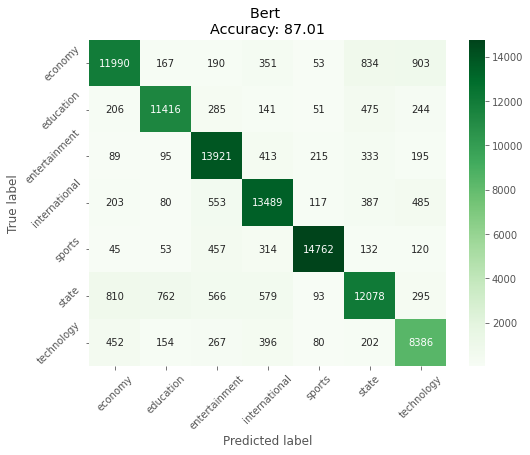

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, y_pred) 

class_names = ['economy','education','entertainment','international','sports','state','technology']
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names, 
                     columns = class_names)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,cmap="Greens", fmt='g')
plt.title('Bert \nAccuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

In [60]:
class_names = ['economy','education','entertainment','international','sports','state','technology']
# predictions = model.predict(X_test)
# y_pred = np.argmax(predictions, axis=1)
report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
report = report.rename(index={'0': 'economy','1':'education','2':'entertainment','3':'international','4':'sports','5':'state',
                              '6': 'technology','7':'International'})
report[['precision','recall','f1-score']]=report[['precision','recall','f1-score']].apply(lambda x: round(x*100,2))
report

,precision,recall,f1-score,support
economy,86.92,82.76,84.79,14488.000000
education,89.70,89.06,89.38,12818.000000
entertainment,85.73,91.22,88.39,15261.000000
international,86.01,88.08,87.03,15314.000000
sports,96.04,92.94,94.46,15883.000000
state,83.64,79.55,81.54,15183.000000
technology,78.90,84.39,81.56,9937.000000
accuracy,87.01,87.01,87.01,0.870131
macro avg,86.70,86.86,86.74,98884.000000
weighted avg,87.11,87.01,87.02,98884.000000


In [56]:
test

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...
...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...


In [59]:
sub=pd.DataFrame({'True':y_test,'Pred_Bert':y_pred})
sub.to_csv('Evaluation_Bert.csv',index=False)